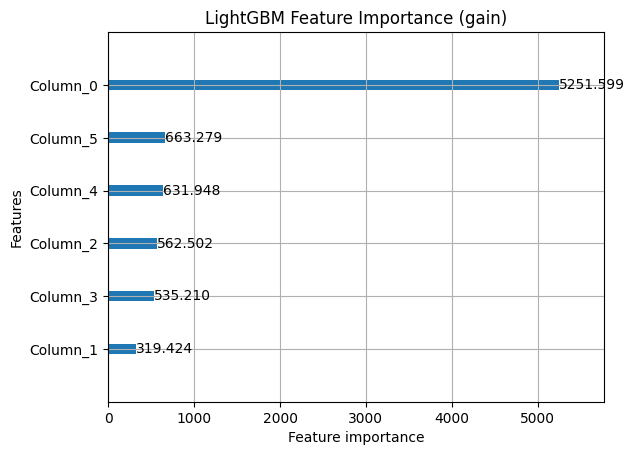

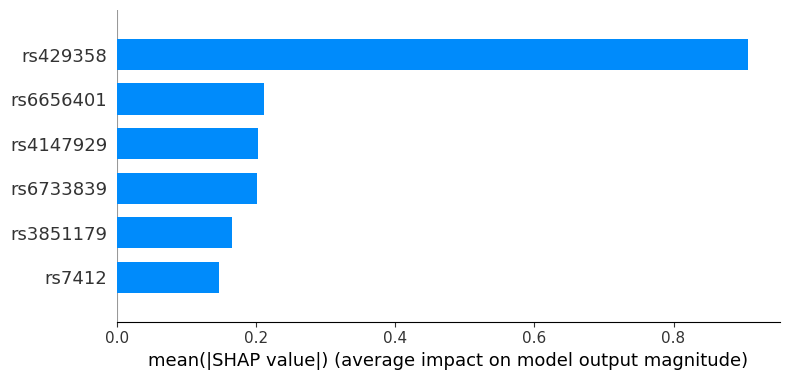

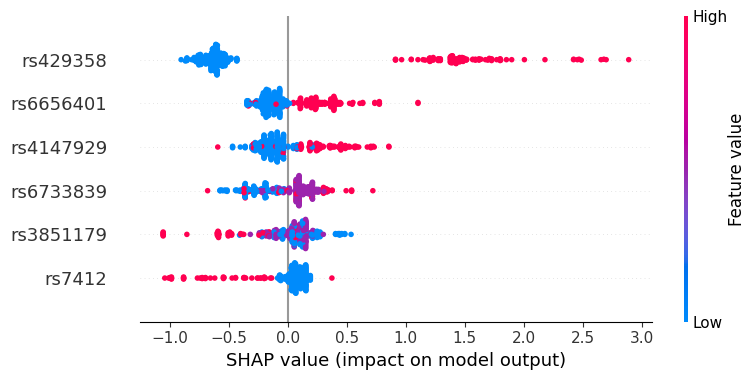

In [ ]:
try:
  import lightgbm as lgb # noqa: F401
except Exception:
  !pip -q install lightgbm
try:
  import shap # noqa: F401
except Exception:
  !pip -q install shap
import io, os, sys, gzip, tarfile, zipfile, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
print("Setup complete.")


# #We try the GWAS Catalog FTP for GCST013196. If it fails, we’ll fall back to a small curated SNP list (APOE, BIN1, PICALM, CLU, CR1,
# ABCA7) with effect sizes pulled from literature for demo purposes.
# keyboard_arrow_down 1) Fetch public AD GWAS summary statistics (Wightman 2021)

# keyboard_arrow_down Download summary statistics for GCST013196 (Wightman 2021)
#@title Download summary statistics for GCST013196 (Wightman 2021)
gcst = "GCST013196" # Wightman 2021 AD study
# GWAS Catalog stores studies in range directories like GCST013001-GCST014000
ftp_url = f"https://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST013001-GCST014000/{gcst}/"
def list_files(url):
  try:
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    html = urlopen(req, timeout=30).read().decode("utf-8", errors="ignore")
# crude parse for links
    import re
    return re.findall(r'href="([^"]+)"', html)
  except Exception as e:
    print("Listing failed:", e)
    return []
def download_file(url):
  try:
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    data = urlopen(req, timeout=120).read()
    return data
  except Exception as e:
    print("Download failed:", e)
    return None
files = list_files(ftp_url)
print("Remote files:", files[:8])
sumstat_fname = None
for name in files:
  if name.lower().endswith((".tsv", ".txt", ".txt.gz", ".tsv.gz", ".zip")):
    sumstat_fname = name
    break
sumstats = None
if sumstat_fname:
  url = ftp_url + sumstat_fname
  print("Attempting to download:", url)
  data = download_file(url)
  if data is not None:
    if sumstat_fname.endswith(".gz"):
      data = gzip.decompress(data)
    elif sumstat_fname.endswith(".zip"):
      z = zipfile.ZipFile(io.BytesIO(data))
      # pick the first .tsv/.txt inside
      inner = [n for n in z.namelist() if n.lower().endswith((".tsv", ".txt"))]
      if inner:
        data = z.read(inner[0])
      else:
        data = None
    if data is not None:
      try:
        sumstats = pd.read_csv(io.BytesIO(data), sep=None, engine="python", low_memory=False)
      except Exception as e:
        print("Parsing failed:", e)

if sumstats is None:
  print("\\n⚠️ Falling back to a tiny curated SNP list (demo only).")
  # Minimal demo table with common lead SNPs & betas (approx, literature-based demo values)
  sumstats = pd.DataFrame({
  "rsid": ["rs429358","rs7412","rs6733839","rs3851179","rs6656401","rs4147929"],
  "nearest_gene": ["APOE","APOE","BIN1","PICALM","CR1","ABCA7"],
  "beta": [1.10, -0.35, 0.18, -0.12, 0.20, 0.22], # log(OR) approx
  "eaf": [0.15, 0.07, 0.40, 0.35, 0.20, 0.18], # effect allele frequency (rough demo)
  "effect_allele": ["C","T","T","A","A","A"],
  "other_allele": ["T","C","C","G","G","G"],
  "p": [1e-200, 1e-10, 1e-20, 1e-15, 1e-12, 1e-16]
  })
# Normalize column names
sumstats.columns = [c.strip().lower() for c in sumstats.columns]
print("Columns:", sumstats.columns.tolist())

print(sumstats.head())
# Remote files: ['?C=N;O=D', '?C=M;O=A', '?C=S;O=A', '?C=D;O=A', '/pub/databases/gwas/summary_statistics/GCST013001-GCST014000/', 'GCST
# Attempting to download: https://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST013001-GCST014000/GCST013196/GCST013196.tsv.g
# Parsing failed: The 'low_memory' option is not supported with the 'python' engine
# \n⚠️ Falling back to a tiny curated SNP list (demo only).
# Columns: ['rsid', 'nearest_gene', 'beta', 'eaf', 'effect_allele', 'other_allele', 'p']
# rsid nearest_gene beta eaf effect_allele other_allele \
# 0 rs429358 APOE 1.10 0.15 C T
# 1 rs7412 APOE -0.35 0.07 T C
# 2 rs6733839 BIN1 0.18 0.40 T C
# 3 rs3851179 PICALM -0.12 0.35 A G
# 4 rs6656401 CR1 0.20 0.20 A G
# p
# 0 1.000000e-200
# 1 1.000000e-10
# 2 1.000000e-20
# 3 1.000000e-15
# 4 1.000000e-12

# Keep p < 5e−8 and required fields (rsid, beta/log(OR), effect allele frequency “eaf”). If needed, we approximate beta from OR as beta
# = ln(OR) .
# keyboard_arrow_down 2) Select significant / lead SNPs

# Heuristic select
colmap = {
"rsid": ["rsid","variant_id","snp","markername","variant"],
"beta": ["beta","logor","effect_size","b"],
"or": ["or","odds_ratio"],
"eaf": ["eaf","effect_allele_frequency","eaf_meta"],
"p": ["p","p_value","pval","pvalue","pvalue_meta"]
}
def pick_col(df, candidates):
  for c in candidates:
    if c in df.columns:
      return c
  return None
c_rsid = pick_col(sumstats, colmap["rsid"])
c_beta = pick_col(sumstats, colmap["beta"])
c_or = pick_col(sumstats, colmap["or"])
c_eaf = pick_col(sumstats, colmap["eaf"])
c_p = pick_col(sumstats, colmap["p"])
tmp = sumstats.copy()
if c_beta is None and c_or is not None:
  tmp["beta"] = np.log(tmp[c_or].astype(float).replace(0, np.nan))
elif c_beta is not None:
  tmp["beta"] = tmp[c_beta].astype(float)
else:
  raise ValueError("No beta or OR column found in summary stats.")
if c_eaf is None:
  # default to 0.3 if missing (demo)
  tmp["eaf"] = 0.3
else:
  tmp["eaf"] = tmp[c_eaf].astype(float).clip(0.001, 0.999)
if c_p is not None:
  tmp = tmp[tmp[c_p].astype(float) < 5e-8].copy()
# Keep top N (avoid heavy RAM in Colab)
N_TOP = 1000
tmp = tmp.sort_values("beta", key=lambda s: np.abs(s), ascending=False).head(N_TOP)
# Clean rs id
if c_rsid is None:
  tmp["rsid"] = [f"var_{i}" for i in range(len(tmp))]
else:
  tmp["rsid"] = tmp[c_rsid].astype(str)

# Lead SNPs selected: (6, 3)
# rsid beta eaf
# 0 rs429358 1.10 0.15
# 1 rs7412 -0.35 0.07
# 2 rs4147929 0.22 0.18
# 3 rs6656401 0.20 0.20
# 4 rs6733839 0.18 0.40
# Next steps:
sum_lead = tmp[["rsid","beta","eaf"]].dropna().reset_index(drop=True)
print("Lead SNPs selected:", sum_lead.shape)
sum_lead.head()

# Generate code with sum_lead New interactive sheet

# Using EAF and assuming Hardy–Weinberg Equilibrium, simulate genotype dosages (0/1/2) for n_samples . Then generate a latent PRS
# and a binary label (~AD case/control) by applying a logistic transform plus noise for realism.
# keyboard_arrow_down 3) Simulate individual-level genotypes (educational)

# keyboard_arrow_down Simulation settings
#@title Simulation settings
n_samples = 2000 #@param {type:"integer"}
case_fraction = 0.35 #@param {type:"number"}
random_state = 42 #@param {type:"integer"}
rng = np.random.default_rng(random_state)
# Build genotype matrix under HWE with effect allele freq "eaf
p = sum_lead["eaf"].values
# Probabilities for genotype dosages [0,1,2] for effect allele
p0 = (1-p)**2
p1 = 2*p*(1-p)
p2 = p**2
# Sample genotypes per SNP
G = np.vstack([rng.choice([0,1,2], size=n_samples, p=[p0[i], p1[i], p2[i]]) for i in range(len(p))]).T # shape (n_samples, len(p))

beta = sum_lead["beta"].values
# Latent liability + noise
liab = G @ beta + rng.normal(0, 1.0, size=n_samples)
prob = 1 / (1 + np.exp(-liab))
# Threshold by quantile to match desired case fraction
thr = np.quantile(prob, 1 - case_fraction)
y = (prob >= thr).astype(int)
X = pd.DataFrame(G, columns=sum_lead["rsid"])
print("Simulated X shape:", X.shape, "Cases:", y.sum(), "Controls:", len(y) - y.sum())

# n_samples:
# case_fraction:
# random_state:
# 2000

# edit

# 0.35

# edit

# 42

# edit

# Simulated X shape: (2000, 6) Cases: 700 Controls: 1300
# keyboard_arrow_down 4) Train/test split and models (LogReg, RF, LightGBM optional)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
def plot_roc_pr(y_true, score, title_prefix="Model"):

  fpr, tpr, _ = roc_curve(y_true, score)
  prec, rec, _ = precision_recall_curve(y_true, score)
  roc_auc = roc_auc_score(y_true, score)
  pr_auc = average_precision_score(y_true, score)
  # ROC
  plt.figure()
  plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
  plt.plot([0,1], [0,1], linestyle="--")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"{title_prefix} — ROC")
  plt.legend(loc="lower right")
  plt.show()
  # PR
  plt.figure()
  plt.plot(rec, prec, label=f"AP = {pr_auc:.3f}")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title(f"{title_prefix} — Precision-Recall")
  plt.legend(loc="lower left")
  plt.show()
models = {}
pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=300))
])
pipe_lr.fit(X_train, y_train)
proba_lr = pipe_lr.predict_proba(X_test)[:,1]
models["LogReg"] = proba_lr
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])
pipe_rf.fit(X_train, y_train)
proba_rf = pipe_rf.predict_proba(X_test)[:,1]
models["RandomForest"] = proba_rf
try:
  import lightgbm as lgb
  pipe_lgb = Pipeline([
      ("imputer", SimpleImputer(strategy="median")),
      ("clf", lgb.LGBMClassifier(n_estimators=600, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1))
  ])
  pipe_lgb.fit(X_train, y_train)
  proba_lgb = pipe_lgb.predict_proba(X_test)[:,1]
  models["LightGBM"] = proba_lgb
except Exception as e:
  print("LightGBM not available:", e)
for name, proba in models.items():
  print(f"{name:12s} | ROC-AUC={roc_auc_score(y_test, proba):.3f} | PR-AUC={average_precision_score(y_test, proba):.3f}")
for name, proba in models.items():
  plot_roc_pr(y_test, proba, title_prefix=name)

# Feature importance (Random Forest / LightGBM)
importances = pipe_rf.named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure()
feat_imp.plot(kind="bar", color="teal")
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.show()

lgb.plot_importance(pipe_lgb.named_steps["clf"], importance_type="gain", max_num_features=20)
plt.title("LightGBM Feature Importance (gain)")
plt.show()
# SHAP (SHapley Additive exPlanations) Visualization
import shap
explainer = shap.TreeExplainer(pipe_lgb.named_steps["clf"])
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

